In [51]:
from typing import TypedDict, Annotated
from langgraph.graph import START,END,StateGraph
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from IPython.display import Image, display, Markdown
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
from langchain_community.document_loaders import PyPDFLoader
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langchain_community.vectorstores import Chroma
import os


load_dotenv()

True

In [26]:
gpt_llm= ChatOpenAI(model="gpt-4o-mini")

In [27]:
class ToolCaller(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [28]:
searchtool =  DuckDuckGoSearchRun(region="us-en")

In [29]:
# Get the directory where the notebook is located
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
pdf_path = os.path.join(notebook_dir, "RentalConditions.pdf")


pdf_loader= PyPDFLoader(pdf_path)
pdf_documents=pdf_loader.load()
splitter=RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
pdf_splitted=splitter.split_documents(pdf_documents)

embeddings=OpenAIEmbeddings(model="text-embedding-3-small",dimensions=1024)
chromadatabase=Chroma.from_documents(pdf_splitted,embeddings)
chromdb_retrieved_docs=chromadatabase.as_retriever(search_kwargs={"k": 3})
retriver_tool=create_retriever_tool(chromdb_retrieved_docs,"Rental_Car_Retriever", "Rental car information to be pulled from this document")

In [30]:
@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic operations on the two numbers.
    Supported operations: add, sub, mul, div
    """

    try: 
        if operation=="add":
            result=first_num+second_num
        elif operation=="sub":
            result=first_num-second_num
        elif operation=="mul":
            result=first_num*second_num
        elif operation=="div":
            result=first_num/second_num
        else:
            return {"error":f"Unsupported operation {operation}"}
        
        return {"first_num":first_num,"second_num":second_num,"operation": operation, "result":result}
    except Exception as e:
        return {"error":str(e)}
        

In [31]:
@tool
def string_manipulation(string_value: str, task: str, splitter: str) -> dict:
    """
    Your task is to perform string manipulation based on user input.
    Task can include - upper, lower, split of strings provided by the user.
    splitter can be of type - (/ , .)
    """

    try: 
        if task=="upper":
            result=string_value.upper()
        elif task=="lower":
            result=string_value.upper()
        elif task=="split":
            if splitter=="/":
                result=string_value.split('/') 
            elif splitter==",":
                result=string_value.split(',')
            elif splitter==".":
                result=string_value.split('.')
            else:
                return {"error":f"Unsupported splitter {splitter}"}
                
        else:
            return {"error":f"Unsupported task {task}"}
        
        return {"string_value":string_value,"task":task,"splitter": splitter, "result":result}
    except Exception as e:
        return {"error":str(e)}

In [32]:
tools = [searchtool,string_manipulation,calculator, retriver_tool]

llm_with_tools= gpt_llm.bind_tools(tools)

In [45]:
def chat_node(state:ToolCaller)-> ToolCaller:
    """LLM node that may answer or request a tool call"""
    
    prompt=f"You are an AI assistant who makes different tool calls and provide answers to the users based on user query: {state['messages']}"

    result=llm_with_tools.invoke(prompt)
    return {"messages":[result]}

tool_node= ToolNode(tools)

In [34]:
graph=StateGraph(ToolCaller)
graph.add_node("chat_node",chat_node)
graph.add_node("tools",tool_node)

graph.add_edge(START,"chat_node")
graph.add_conditional_edges("chat_node",tools_condition)
graph.add_edge("tools","chat_node")



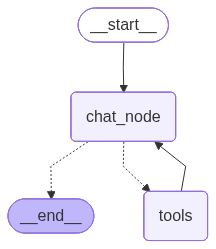

In [35]:
workflow=graph.compile()

display(Image(workflow.get_graph().draw_mermaid_png()))

In [36]:
workflow.invoke({"messages":"What is cricket?"})

{'messages': [HumanMessage(content='What is cricket?', additional_kwargs={}, response_metadata={}, id='aeba1806-d0ee-438c-abdf-628b54380c7b'),
  AIMessage(content='Cricket is a bat-and-ball game played between two teams, typically consisting of 11 players each. It is one of the most popular sports in the world, particularly in countries such as India, Australia, England, Pakistan, and South Africa. \n\n### Basic Rules and Structure:\n1. **Objective**: The main objective of cricket is for one team to score runs while the other team tries to restrict the runs and dismiss the players.\n  \n2. **Playing Field**: The game is played on a circular or oval-shaped field with a 22-yard long rectangular pitch at the center. \n\n3. **Innings**: Each team gets a chance to bat and bowl (or field), and this is referred to as an "innings." The number of innings varies in different formats of the game.\n\n4. **Scoring Runs**: Runs are scored in various ways, primarily by hitting the ball and running be

In [37]:
workflow.invoke({"messages":"help me doing the upper case for the text 'hello' "})

{'messages': [HumanMessage(content="help me doing the upper case for the text 'hello' ", additional_kwargs={}, response_metadata={}, id='b3159b83-2835-45aa-8ba6-21c9cd4e3a72'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dXCQniElm3W2Jc7iAJWj59A0', 'function': {'arguments': '{"string_value":"hello","task":"upper","splitter":""}', 'name': 'string_manipulation'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 230, 'total_tokens': 256, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CQoi5Jj1hNlpksjIQb6d3MNYnFaaj', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--04d62b7f-2d76-4272-8f1a-1040f9e44672-0', tool_ca

In [38]:
workflow.invoke({"messages":"How do I split the text? 'India/Gaurav/Singapore' "})

{'messages': [HumanMessage(content="How do I split the text? 'India/Gaurav/Singapore' ", additional_kwargs={}, response_metadata={}, id='6bbd1475-3ef0-4168-8c19-82a441d92875'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_W71FSCiS1LCrDHiHyRAwx4N9', 'function': {'arguments': '{"string_value":"India/Gaurav/Singapore","task":"split","splitter":"/"}', 'name': 'string_manipulation'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 234, 'total_tokens': 266, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CQoibioxmgb7GBGe96nXGBjPOLVLi', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--aa42cfe1-7201-4fd2-9efd-af3b80

In [39]:
workflow.invoke({"messages":"what is the stock price of tesla?"})

{'messages': [HumanMessage(content='what is the stock price of tesla?', additional_kwargs={}, response_metadata={}, id='9f93ac65-cbf3-4d06-b9ad-bf7ba2f5e00e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KWiU4QdA2b87nBrw4t0xinIN', 'function': {'arguments': '{"query":"current stock price of Tesla"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 226, 'total_tokens': 247, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CQoigtwWI6YczxaGZlhWb9Ny2X5Om', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2a3b1c6a-daaf-4c4b-8842-7ed593940a1f-0', tool_calls=[{'name': 'duckduckgo_search

In [ ]:
result=workflow.invoke({"messages":"what is the deposit amount for car rental?"})
print("Question:", result['messages'][0].content)
print("Answer:",result['messages'][-1].content)
print(50*"==")

result=workflow.invoke({"messages":"What is cricket?"})
print("Question:", result['messages'][0].content)
print("Answer:",result['messages'][-1].content)
print(50*"==")

result=workflow.invoke({"messages":"help me doing the upper case for the text 'hello' "})
print("Question:", result['messages'][0].content)
print("Answer:",result['messages'][-1].content)
print(50*"==")

result=workflow.invoke({"messages":"How do I split the text? 'India/Gaurav/Singapore' "})
print("Question:", result['messages'][0].content)
print("Answer:",result['messages'][-1].content)
print(50*"==")

result=workflow.invoke({"messages":"what is the stock price of tesla?"})
print("Question:", result['messages'][0].content)
print("Answer:",result['messages'][-1].content)
print(50*"==")

result=workflow.invoke({"messages":"what is 3-2?"})
print("Question:", result['messages'][0].content)
print("Answer:",result['messages'][-1].content)
print(50*"==")

Question: what is the deposit amount for car rental?
Answer: The estimated deposit amount for car rental is 500.00 NZD. This security deposit will be blocked on the driver's credit card upon collection of the car.
Question: What is cricket?
Answer: Cricket is a bat-and-ball game played between two teams, typically consisting of 11 players each. It is popular in many countries, particularly in England, Australia, India, Pakistan, South Africa, and the Caribbean. Here's a brief overview of the game:

### Objective
The main objective in cricket is to score runs by hitting the ball and running between a set of wickets while trying to prevent the opposing team from getting them out.

### Equipment
- **Bat**: A flat, elongated piece of wood used to hit the ball.
- **Ball**: A hard, leather ball used in gameplay.
- **Wickets**: Each team has a set of three wooden stumps (wickets) at both ends of a rectangular pitch.

### Format
Cricket can be played in different formats, including:
- **Test C

In [52]:
result=workflow.invoke({"messages":"what is quantum physics??"})
print("Question:", result['messages'][0].content)
print("Answer:",result['messages'][-1].content)
Markdown(result['messages'][-1].content)

Question: what is quantum physics??
Answer: Quantum physics, or quantum mechanics, is a fundamental theory in physics that describes the physical properties of nature at the scale of atoms and subatomic particles. It fundamentally differs from classical physics in several ways:

1. **Wave-Particle Duality**: Quantum objects (such as electrons and photons) exhibit both particle-like and wave-like behavior. This means they can behave like discrete particles in some experiments and like waves in others.

2. **Quantization**: Energy, momentum, and other quantities are quantized, meaning they can only take on discrete values rather than a continuous range. For example, electrons in an atom can only exist in specific energy levels.

3. **Uncertainty Principle**: Formulated by Werner Heisenberg, this principle states that certain pairs of physical properties (like position and momentum) cannot be simultaneously measured with arbitrary precision. The more precisely one property is measured, th

Quantum physics, or quantum mechanics, is a fundamental theory in physics that describes the physical properties of nature at the scale of atoms and subatomic particles. It fundamentally differs from classical physics in several ways:

1. **Wave-Particle Duality**: Quantum objects (such as electrons and photons) exhibit both particle-like and wave-like behavior. This means they can behave like discrete particles in some experiments and like waves in others.

2. **Quantization**: Energy, momentum, and other quantities are quantized, meaning they can only take on discrete values rather than a continuous range. For example, electrons in an atom can only exist in specific energy levels.

3. **Uncertainty Principle**: Formulated by Werner Heisenberg, this principle states that certain pairs of physical properties (like position and momentum) cannot be simultaneously measured with arbitrary precision. The more precisely one property is measured, the less precisely the other can be controlled or known.

4. **Superposition**: Quantum systems can exist in multiple states at once until measured. This concept is famously illustrated by Schrödinger's cat thought experiment, where a cat is simultaneously alive and dead until observed.

5. **Entanglement**: Quantum entanglement occurs when particles become interconnected in such a way that the state of one particle instantaneously affects the state of another, no matter the distance between them. This phenomenon has been experimentally verified and challenges classical intuitions about locality and information transfer.

Quantum physics underlies the behavior of atoms and molecules, leading to the development of applications such as semiconductors, lasers, and quantum computing. It represents a significant departure from classical physics and has profound implications for our understanding of the universe.